## Building Micrograd

The following Jupyter notebook has been adapted from the tutorial for [building Micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0), by Andrej Karpathy.

Neural networks - take input data and weights, perform a mathematical operation, and output a prediction or loss function. Neural networks are simply a class of mathematical expressions.

Back propogation - is not restricted to neural networks. It provides arbitrary mathematical expressions that can be used for the training of neural networks.

1. "derivative of a simple function with one input"...

In [32]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def f(x):
    return 3*x**2 - 4*x + 5

In [34]:
f(3.0)

20.0

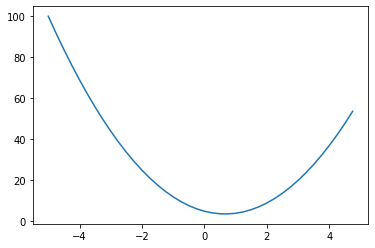

In [35]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

The derivative of a function represents the slope, or sensitivity of change, of a function's output with respect to its input.

In [36]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

2. "derivative of a function with multiple inputs"...

In [37]:
# Let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print('d =', d)

d = 4.0


In [38]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
a += h
d2 = a*b+c
print('d1 =', d1)
print('d2 =', d2)
print('slope = ', (d2-d1)/h)

d1 = 4.0
d2 = 3.999699999999999
slope =  -3.000000000010772


In [39]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
b += h
d2 = a*b+c
print('d1 =', d1)
print('d2 =', d2)
print('slope = ', (d2-d1)/h)

d1 = 4.0
d2 = 4.0002
slope =  2.0000000000042206


In [40]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
c += h
d2 = a*b+c
print('d1 =', d1)
print('d2 =', d2)
print('slope = ', (d2-d1)/h)

d1 = 4.0
d2 = 4.0001
slope =  0.9999999999976694


3. "starting the core Value object of micrograd and its visualization"...

In [77]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        # return f"Value(data={self.data}, _children={self._prev}, _op={self._op})"
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L


Value(data=-8.0)

Now for some code to help visualize an expression graph...

In [57]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

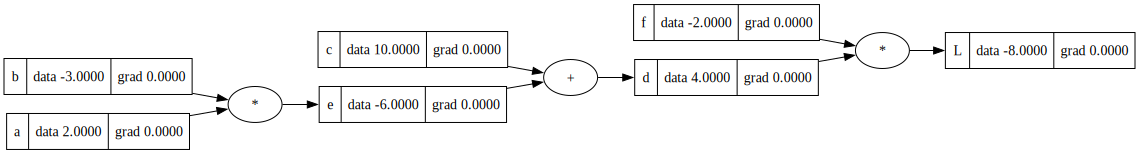

In [58]:
draw_dot(L)

4. "manual backpropagation example #1: simple expression"

In [66]:
# Fill in the gradients for the nodes in the expression graph
L.grad = 1.0
L = d*f
# dl/dd = f
# Proof:
#   (f(x+h)-f)/h
#   ((d+h)*f - d*f)/h
#   ((d*f + h*f) - d*f)/h
#   h*f/h
#   = f
# dl/df = d
f.grad = 4.0
d.grad = -2.0

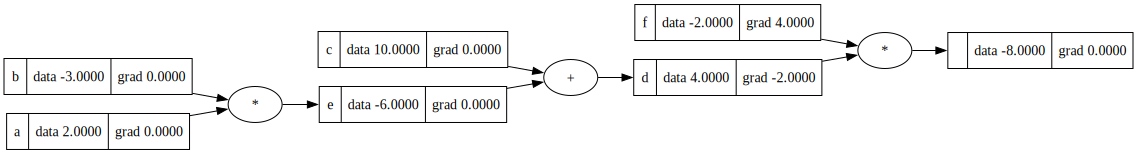

In [62]:
draw_dot(L)

* dd/dc = ?
    * d = c + e
    * (f(x+h) - f(x)) / h
    * ((c+h + e) - (c+e)) / h
    * (c + h + e - c - e) / h
    * h / h = 1.0 => dd/dc
    * dd/de = 1.0
    * Chain rule allows us to find dL/dc
        * ex. If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well via the intermediate variable y.
        * dz/dx = dz/dy * dy/dx
        * ex. "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2*4 = 8 times as fast as the man."

* want:
    * dL / dc = dL/dd * dd/dc

* know:
    * dL/dd
    * dd/dc

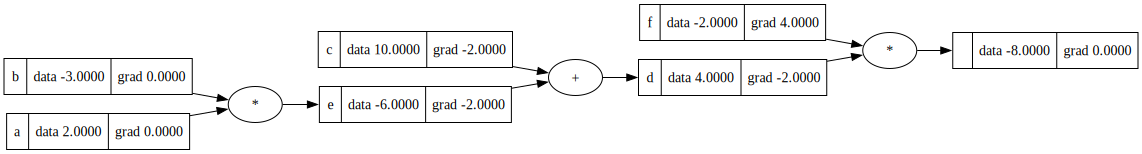

In [63]:
c.grad = -2.0
e.grad = -2.0
draw_dot(L)

* dL/de = -2.0

* want:
    * dL/da = dL/de * de/da

* e = a * b
    * de/da = b = -3.0
    * de/db = a = 2.0

* dL/da = -2.0 * 2.0 = -4.0

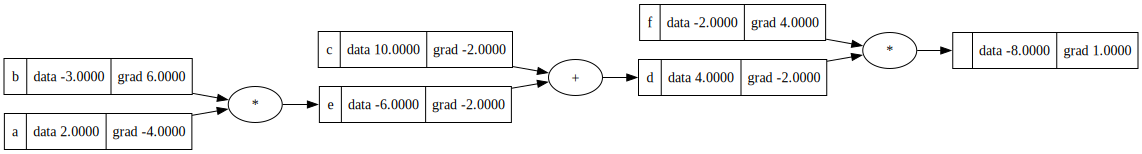

In [68]:
a.grad = 2.0 * -2.0
b.grad = -3.0 * -2.0
L.grad = 1.0

draw_dot(L)

5. "preview of a single optimization step"

In [70]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f
print(L.data)


-8.506368000000002


6. "manual backpropagation example #2: a neuron"

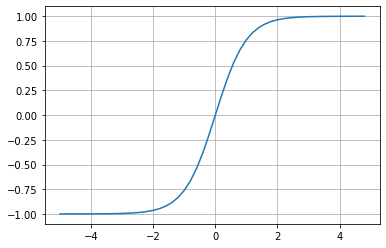

In [72]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

The "tanh" activation function is plotted above. This activation function squashes large positive values by leveling at 1 and squashes large negative values by leveling at -1.

In [101]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [102]:
o.grad = 1.0


In [103]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
#       = 1 - o**2
n.grad = 1 - o.data**2

In [104]:
# Addition is simply a distributor of gradients
# This is due to the local derivatives being 1
x1w1x2w2.grad = 1*0.5
b.grad = 1*0.5

In [105]:
x2w2.grad = 1*0.5
x1w1.grad = 1*0.5

In [107]:
# Multiplication results in a local derivative that's the other term
# Recall the chain rule
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

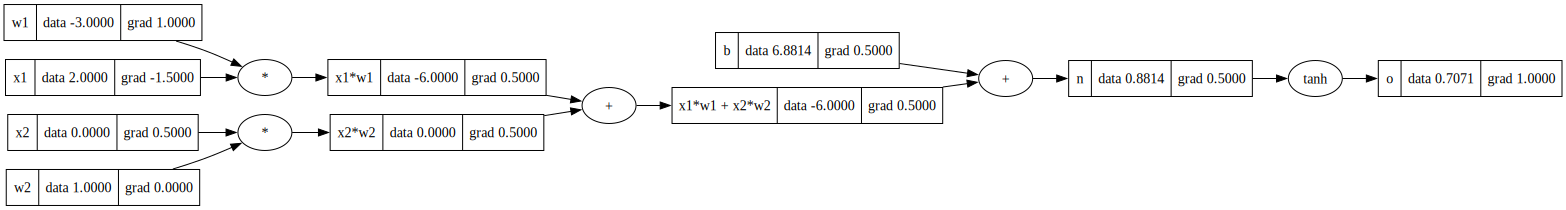

In [108]:
draw_dot(o)

7. "Implementing the backward function for a while expression graph"